In [1]:
#Importing the packages
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,Activation,BatchNormalization,Add,Multiply,Concatenate,GlobalAveragePooling2D,Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from keras.layers import Layer
import datetime
import pandas as pd
import time
from glob import glob


2024-04-26 20:40:20.742237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 20:40:20.742374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 20:40:20.930567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## ALL HELPER FUNCTIONS

In [2]:
#Importing the packages
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.layers import Input,Conv2D,Activation,BatchNormalization
from keras.layers import Add,Multiply,Concatenate,GlobalAveragePooling2D,Subtract
from keras.models import Model
from keras.layers import Layer


def get_patches_save(filepath,patch_size,crop_sizes,save_dir=None):
    '''This functions creates and return patches of given image with a specified patch_size, if save_dir is given patches are saved to the directory'''
    image = cv2.imread(filepath)
    filename=filepath.split('/')[-1].split('.')[0]
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
              x = image_scaled[i:i+patch_size, j:j+patch_size] # This gets the patch from the original image with size patch_size x patch_size

              if save_dir!=None:  #If save_dir is specified we will save the patches to the given directory
                if not os.path.exists(save_dir):
                  os.mkdir(save_dir)
                pactch_filepath=save_dir+'/'+filename+'_'+str(crop_h)+'_'+str(i)+'_'+str(j)+'.jpg'# Creating a distinct patch filename
                cv2.imwrite(pactch_filepath,x) # Saving the  image to the path

              patches.append(x)
    return patches
  

def create_data(data_dir,save_dir=None):
  '''This function create data for all the images present in a directory'''
  files_list=os.listdir(data_dir)
  print('Number of files in the '+data_dir+' is : '+str(len(files_list)))
  patch_size = 40
  crop_sizes = [1, 0.8, 0.7,0.5]
  data=[]
  for file in files_list:
    if file.endswith('.jpg'):
      patches=get_patches_save(data_dir+'/'+file,patch_size,crop_sizes,save_dir)
      data+=patches
  return data


def create_image_from_patches(patches,image_shape):
  '''This function takes the patches of images and reconstructs the image'''
  image=np.zeros(image_shape) # Create a image with all zeros with desired image shape
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] # Assigning values of pixels from patches to image
      p+=1
  return np.array(image)


def predict_fun(model,image_path,noise_level=30):
  #Creating patches for test image
  patches=get_patches_save(image_path,40,[1])
  test_image=cv2.imread(image_path)

  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  #predicting the output on the patches of test image
  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  #Creating entire denoised image from denoised patches
  denoised_image=create_image_from_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image



def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):
    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()


def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


def PSNR(gt, image, max_value=1):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))


## models functions
class EAM(Layer):
    def __init__(self, **kwargs):
        super(EAM, self).__init__(**kwargs)
        self.conv1a = Conv2D(64, (3,3), dilation_rate=1, padding='same', activation='relu')
        self.conv1b = Conv2D(64, (3,3), dilation_rate=2, padding='same', activation='relu')
        self.conv2a = Conv2D(64, (3,3), dilation_rate=3, padding='same', activation='relu')
        self.conv2b = Conv2D(64, (3,3), dilation_rate=4, padding='same', activation='relu')
        self.concat = Concatenate(axis=-1)
        self.conv3 = Conv2D(64, (3,3), padding='same', activation='relu')
        self.add1 = Add()
        self.conv4a = Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv4b = Conv2D(64, (3,3), padding='same')
        self.add2 = Add()
        self.activation1 = Activation('relu')
        self.conv5a = Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv5b = Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv5c = Conv2D(64, (1,1), padding='same')
        self.add3 = Add()
        self.activation2 = Activation('relu')
        self.global_pooling = GlobalAveragePooling2D()
        self.expand_dims1 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 1))
        self.expand_dims2 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 1))
        self.conv6a = Conv2D(4, (3,3), padding='same', activation='relu')
        self.conv6b = Conv2D(64, (3,3), padding='same', activation='sigmoid')
        self.multiply = Multiply()

    def call(self, input):
        x = self.conv1a(input)
        x = self.conv1b(x)

        y = self.conv2a(input)
        y = self.conv2b(y)

        z = self.concat([x, y])
        z = self.conv3(z)
        add_1 = self.add1([z, input])

        z = self.conv4a(add_1)
        z = self.conv4b(z)
        add_2 = self.add2([z, add_1])
        add_2 = self.activation1(add_2)

        z = self.conv5a(add_2)
        z = self.conv5b(z)
        z = self.conv5c(z)
        add_3 = self.add3([z, add_2])
        add_3 = self.activation2(add_3)

        z = self.global_pooling(add_3)
        z = self.expand_dims1(z)
        z = self.expand_dims2(z)
        z = self.conv6a(z)
        z = self.conv6b(z)
        mul = self.multiply([z, add_3])
        return mul


def RIDNET():
    input_layer = Input((40, 40, 3), name='input')
    feat_extraction = Conv2D(64, (3,3), padding='same')(input_layer)
    
    eam_1 = EAM()(feat_extraction)
    eam_2 = EAM()(eam_1)
    eam_3 = EAM()(eam_2)
    eam_4 = EAM()(eam_3)
    
    x = Conv2D(3, (3,3), padding='same')(eam_4)
    add_2 = Add()([x, input_layer])
    
    model = Model(input_layer, add_2)
    return model


def DnCNN():
    input = Input(shape=(40,40,3),name='input')
    x = Conv2D(64,kernel_size= (3,3), padding='same',name='conv2d_l1')(input)
    x = Activation('relu',name='act_l1')(x)
    for i in range(17):
        x = Conv2D(64, kernel_size=(3,3), padding='same',name='conv2d_'+str(i))(x)
        x = BatchNormalization(axis=-1,name='BN_'+str(i))(x)
        x = Activation('relu',name='act_'+str(i))(x)   
    x = Conv2D(3, kernel_size=(3,3), padding='same',name='conv2d_l3')(x)
    x = Subtract(name='subtract')([input, x])   
    model = Model(input,x)
    return model

## HyperParameters

In [3]:
BATCH_SIZE=64
NOISE_LEVELS=[15,25,50]
seed = 6908
lr = 1e-04
epoch=5
image_patch_size = (40, 40, 3)

tf.random.set_seed(seed)
strategy = tf.distribute.MirroredStrategy()
num_gpus = strategy.num_replicas_in_sync

## decorate BSDS500 dataset
BSDS500 dataset has:
200 train, 200 test, 100 valid
- I will use 400 for training and 100 for validation (No testing)

In [4]:
## create project directory-tree
os.mkdir('/kaggle/working/results')
os.mkdir('/kaggle/working/data')
os.mkdir("/kaggle/working/data/train")
os.mkdir("/kaggle/working/data/test")
os.mkdir('/kaggle/working/data/patches')
os.mkdir('/kaggle/working/data/patches/train')
os.mkdir('/kaggle/working/data/patches/test')

!cp -r '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/train/.' "/kaggle/working/data/train"
!cp -r '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/test/.' "/kaggle/working/data/train"
!cp -r '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/val/.' "/kaggle/working/data/test"

## Create Patches from images

In [5]:
train_path = '/kaggle/working/data/train'
test_path = '/kaggle/working/data/test'

train_save = '/kaggle/working/data/patches/train'
test_save = '/kaggle/working/data/patches/test'

create_data(train_path, train_save)
print('Number of pactches obtained from train data : ',len(os.listdir(train_save)))
print('--'*20)
create_data(test_path,test_save)
print('Number of pactches obtained from test data : ',len(os.listdir(test_save)))

Number of files in the /kaggle/working/data/train is : 401
Number of pactches obtained from train data :  85600
----------------------------------------
Number of files in the /kaggle/working/data/test is : 101
Number of pactches obtained from test data :  21400


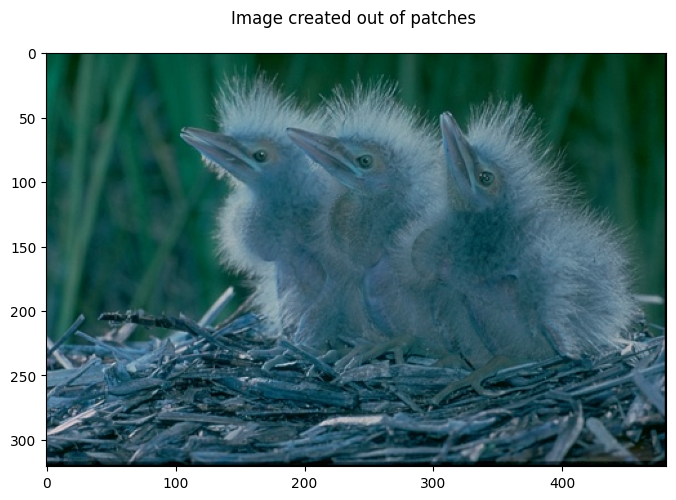

In [6]:
# test create_image_from_patches function
patches=get_patches_save(test_path+"/163085.jpg",40,[1]) 
test_image=cv2.imread(test_path+"/163085.jpg")
patches=np.array(patches)
image_created=create_image_from_patches(patches,test_image.shape)

fig= plt.figure(figsize=(8,8))
plt.imshow(image_created/255.)
plt.title('Image created out of patches \n')
plt.show()

## Load and preprocess dataset

In [7]:
def _parse_function(filename):
    '''This function performs adding noise to the image given by Dataset'''
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.
    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(40,40,3),mean=0,stddev=noise_level/255)
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)
    return noisy_image,image

In [8]:
#Getting the filepaths for train and test data
train_files = glob(train_save+'/*.jpg')
test_files = glob(test_save+'/*.jpg')

In [9]:
#Creating the Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(np.array(test_files))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
## Check dataset integrity
iterator = iter(train_dataset)
a, b = iterator.get_next()

print('Shape of single batch of x : ',a.shape)
print('Shape of single batch of y : ',b.shape)

Shape of single batch of x :  (64, 40, 40, 3)
Shape of single batch of y :  (64, 40, 40, 3)


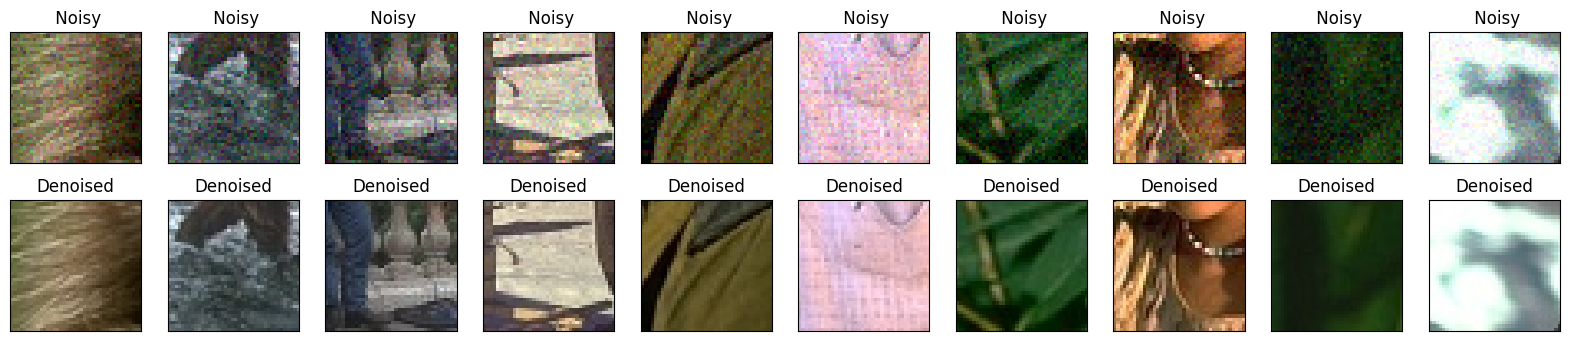

In [11]:
#Plotting the images from dataset to verify the dataset
plot_patches(a, b)

## Models

### RIDNET (paper model)

In [12]:
ridnet = RIDNET()

ridnet.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MeanAbsoluteError())
ridnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 40, 40, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 40, 40,    │      1,792 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eam (EAM)           │ (None, 40, 40,    │    378,052 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eam_1 (EAM)         │ (None, 40, 40,    │    378,052 │ eam[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eam_2 (EAM)         │ (None, 40, 40,    │    378,052 │ eam_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eam_3 (EAM)         │ (None, 40, 40,    │    378,052 │ eam_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 40, 40, 3) │      1,731 │ eam_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 40, 40, 3) │          0 │ conv2d_49[0][0],  │
│                     │                   │            │ input[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,515,731 (5.78 MB)

 Trainable params: 1,515,731 (5.78 MB)

 Non-trainable params: 0 (0.00 B)

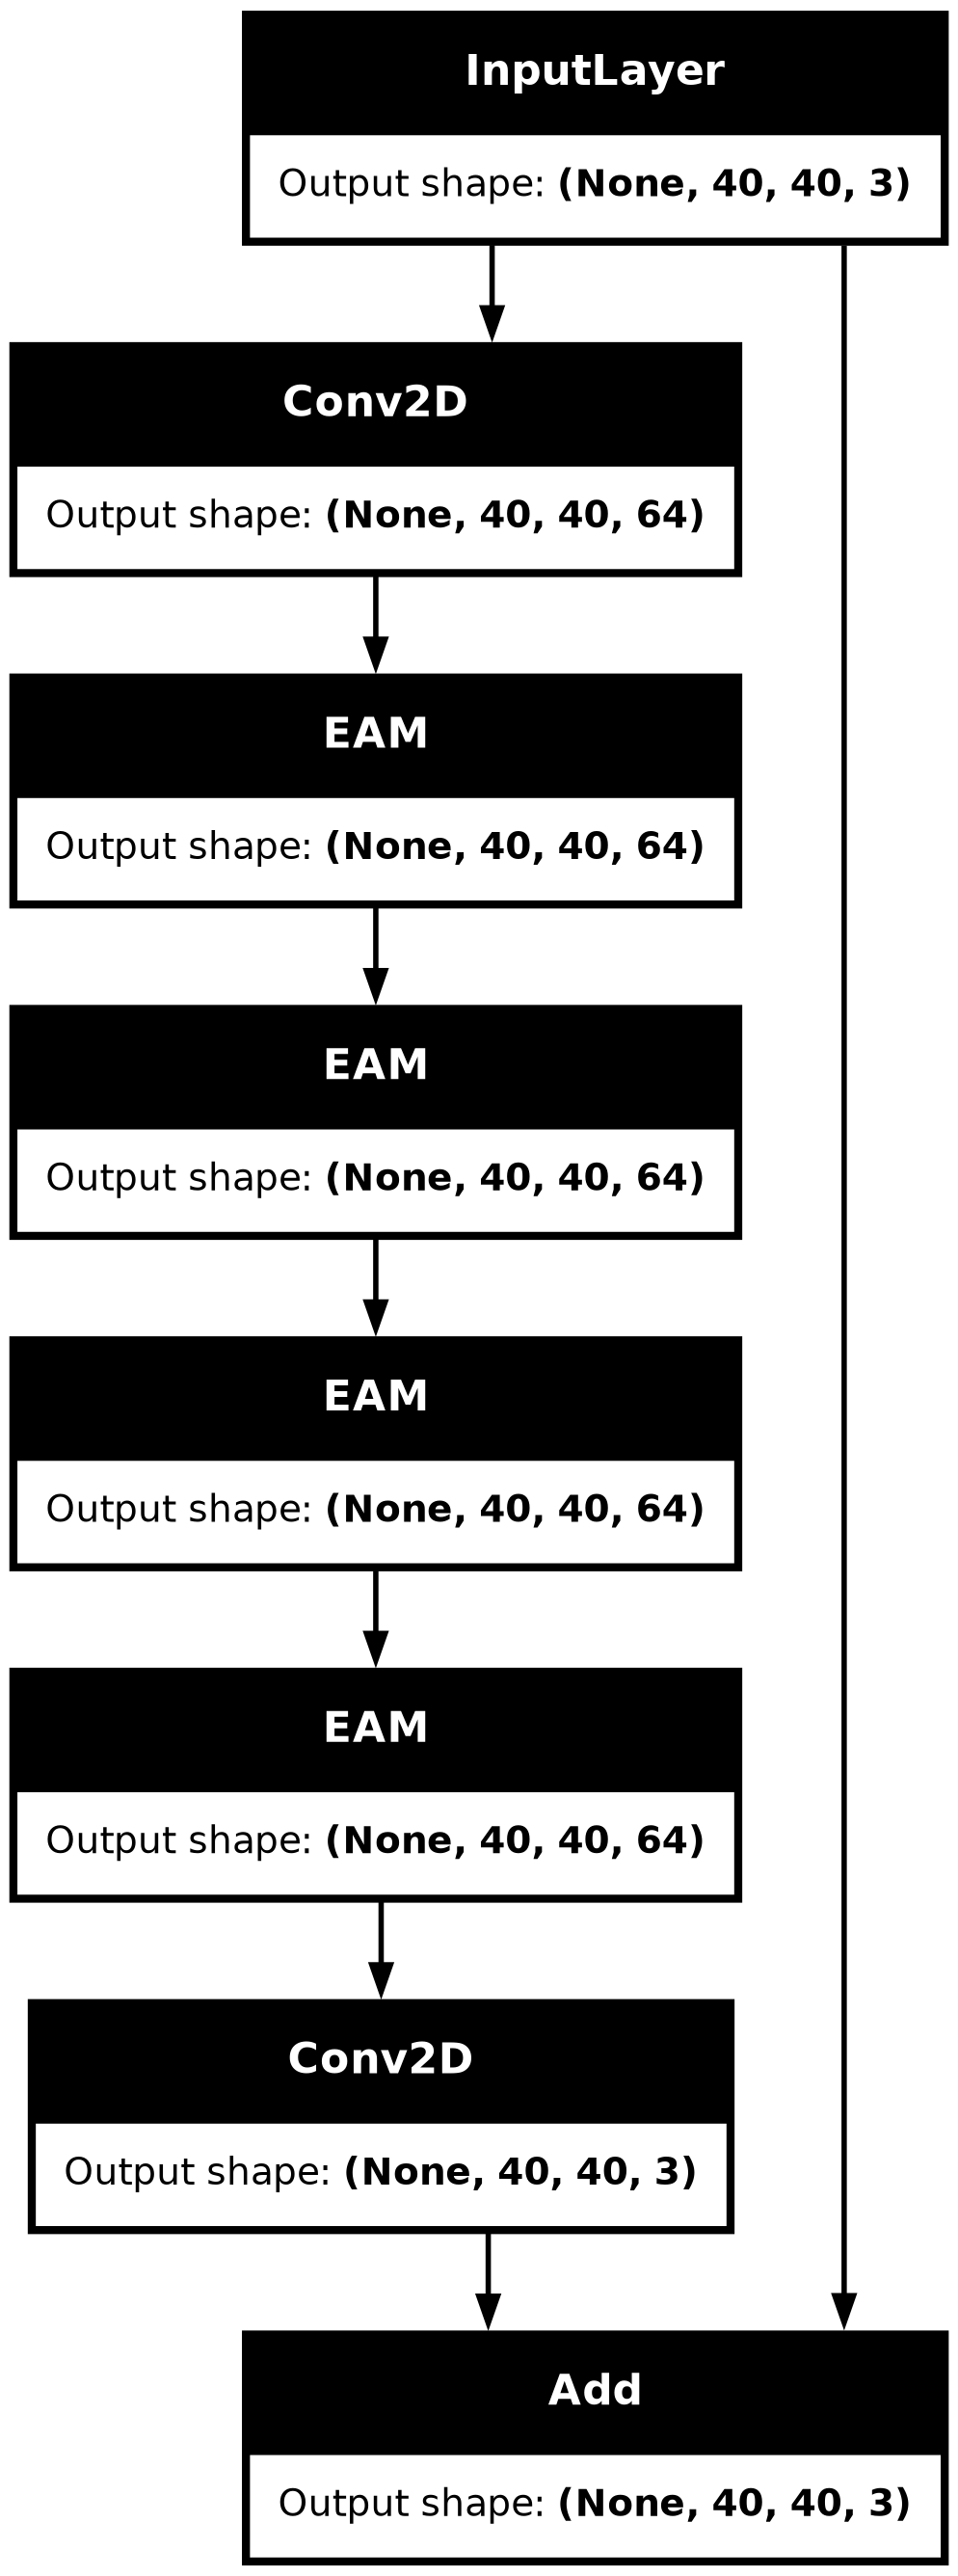

In [13]:
plot_model(ridnet,show_shapes=True,to_file='/kaggle/working/results/ridnet.png')

In [14]:
## define callbacks
checkpoint_path = "/kaggle/working/results/ridnet.keras" # For each epoch creaking a checkpoint
checkpoint_dir = os.path.dirname(checkpoint_path)
def scheduler(epoch,lr):
  return lr*0.9

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=False) # To save the model if the metric is improved
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [cp_callback,lrScheduler]


In [15]:
ridnet_hist = ridnet.fit(train_dataset,shuffle=True,epochs=epoch,validation_data= test_dataset,callbacks=callbacks)


Epoch 1/5


I0000 00:00:1714164091.717972      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1338/1338 ━━━━━━━━━━━━━━━━━━━━ 426s 295ms/step - loss: 0.0296 - val_loss: 0.0870 - learning_rate: 9.0000e-05
Epoch 2/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 405s 282ms/step - loss: 0.0186 - val_loss: 0.0866 - learning_rate: 8.1000e-05
Epoch 3/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 377s 282ms/step - loss: 0.0179 - val_loss: 0.0863 - learning_rate: 7.2900e-05
Epoch 4/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 381s 281ms/step - loss: 0.0176 - val_loss: 0.0865 - learning_rate: 6.5610e-05
Epoch 5/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 382s 281ms/step - loss: 0.0173 - val_loss: 0.0869 - learning_rate: 5.9049e-05


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
PSNR of Noisy Image :  20.323846300397463
PSNR of Denoised Image :  26.269347947550177


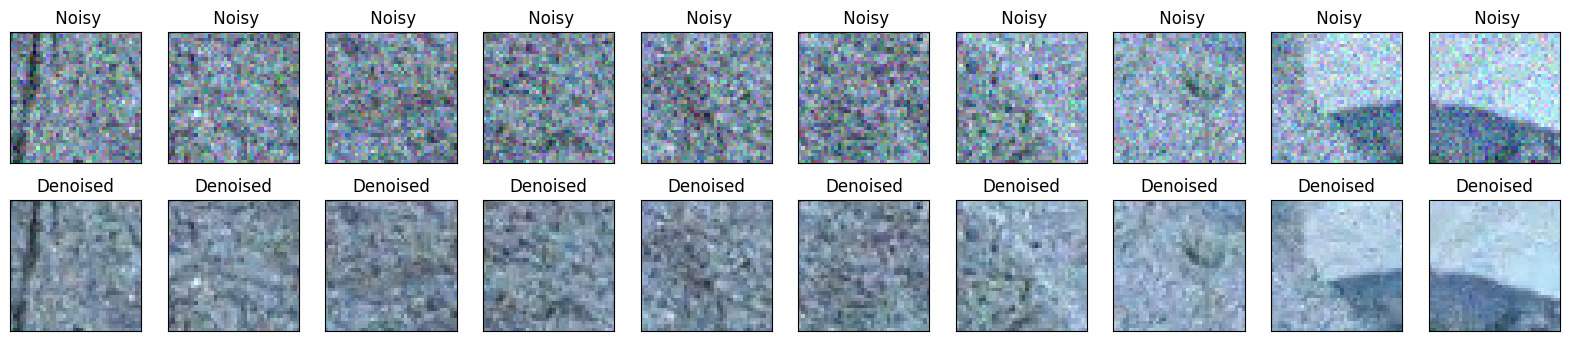

In [16]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(ridnet,'/kaggle/working/data/test/41069.jpg',noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

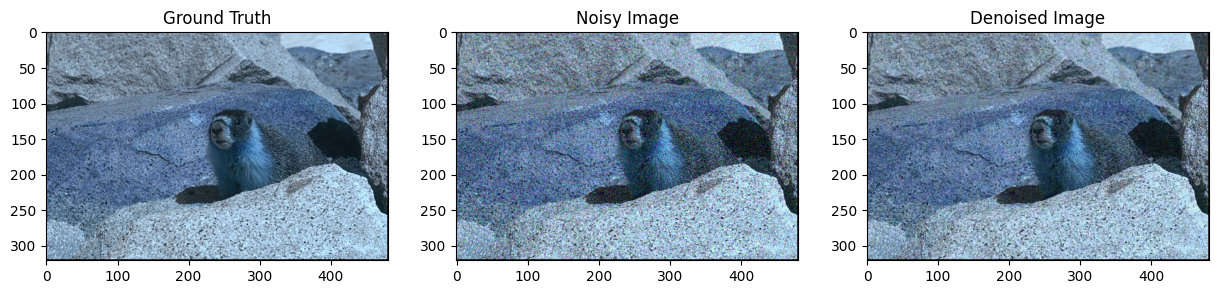

In [17]:
plot_predictions(ground_truth,noisy_image,denoised_image)

## DnCNN

In [18]:
tf.keras.backend.clear_session()
dncnn=DnCNN()
dncnn.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MeanSquaredError())
dncnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 40, 40, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_l1 (Conv2D)  │ (None, 40, 40,    │      1,792 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_l1 (Activation) │ (None, 40, 40,    │          0 │ conv2d_l1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_0 (Conv2D)   │ (None, 40, 40,    │     36,928 │ act_l1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BN_0                │ (None, 40, 40,    │        256 │ conv2d_0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_0 (Activation)  │ (None, 40, 40,    │          0 │ BN_0[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │     36,928 │ act_0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BN_1                │ (None, 40, 40,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_1 (Activation)  │ (None, 40, 40,    │          0 │ BN_1[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 40, 40,    │     36,928 │ act_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BN_2                │ (None, 40, 40,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_2 (Activation)  │ (None, 40, 40,    │          0 │ BN_2[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 40, 40,    │     36,928 │ act_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BN_3                │ (None, 40, 40,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_3 (Activation)  │ (None, 40, 40,    │          0 │ BN_3[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │     36,928 │ act_3[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BN_4                │ (None, 40, 40,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                 

 Total params: 635,651 (2.42 MB)

 Trainable params: 633,475 (2.42 MB)

 Non-trainable params: 2,176 (8.50 KB)

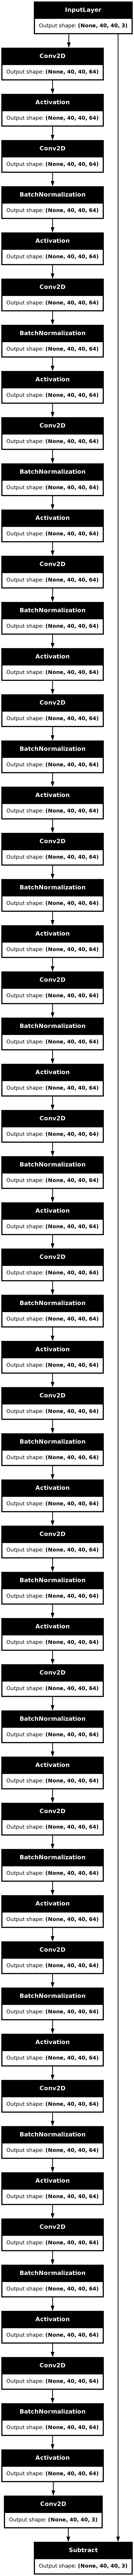

In [19]:
plot_model(dncnn,show_shapes=True,to_file='/kaggle/working/results/dncnn.png')

In [20]:
checkpoint_path = "/kaggle/working/results/dncnn.keras" # For each epoch creaking a checkpoint
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=False) # To save the model if the metric is improved
callbacks = [cp_callback,lrScheduler]


In [21]:
dncnn.fit( train_dataset,shuffle=True,epochs=epoch,validation_data= test_dataset,callbacks=callbacks)


Epoch 1/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 186s 127ms/step - loss: 0.0443 - val_loss: 0.0317 - learning_rate: 9.0000e-05
Epoch 2/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 162s 121ms/step - loss: 0.0034 - val_loss: 0.0316 - learning_rate: 8.1000e-05
Epoch 3/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 202s 121ms/step - loss: 0.0033 - val_loss: 0.0305 - learning_rate: 7.2900e-05
Epoch 4/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 161s 120ms/step - loss: 0.0029 - val_loss: 0.0286 - learning_rate: 6.5610e-05
Epoch 5/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 160s 120ms/step - loss: 0.0022 - val_loss: 0.0230 - learning_rate: 5.9049e-05


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
PSNR of Noisy Image :  20.330421724820912
PSNR of Denoised Image :  22.437982916240845


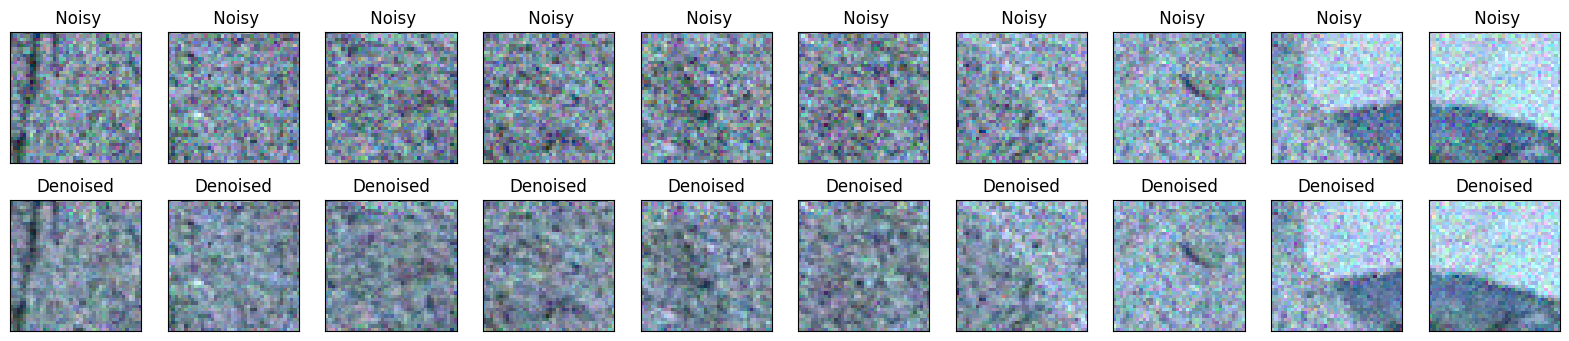

In [22]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'/kaggle/working/data/test/41069.jpg',noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

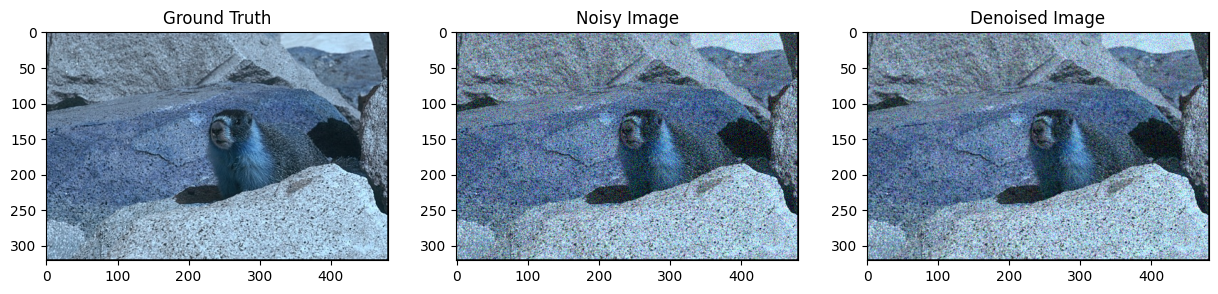

In [23]:
plot_predictions(ground_truth,noisy_image,denoised_image)

## Check Results of two models

In [24]:
results=pd.DataFrame(columns=['Noise Level','Noise Image','DnCNN','RIDNET'])

In [25]:
def get_results(results,noise_level):

  patches_noisy_d,denoised_patches_d,ground_truth,noisy_image_d,denoised_image_d=predict_fun(dncnn,'/kaggle/working/data/test/41069.jpg',noise_level=noise_level)
  patches_noisy_r,denoised_patches_r,ground_truth,noisy_image_r,denoised_image_r=predict_fun(ridnet,'/kaggle/working/data/test/41069.jpg',noise_level=noise_level)
  
  results.loc[len(results.index)]=[noise_level,
                                   PSNR(ground_truth,noisy_image_r),
                                   PSNR(ground_truth,denoised_image_d),
                                   PSNR(ground_truth,denoised_image_r)]

  return results

In [26]:
noises = [15,20,25,30,40,45]
for noise in noises:
    results=get_results(results,noise)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [27]:
print('Tabulating the model results with different noise level \n')
results.head(6)

Tabulating the model results with different noise level 



Noise Level  Noise Image      DnCNN     RIDNET
0         15.0    24.691699  26.894720  30.738321
1         20.0    22.252255  24.480107  28.598721
2         25.0    20.350896  22.439021  26.296600
3         30.0    18.802763  20.685871  24.298528
4         40.0    16.449118  17.900429  21.167102
5         45.0    15.511928  16.771118  19.966468

## RIDNET is performing better than the DnCNN model. But the number trainable parameter in RidNET is comparatively higher than the other two models.